# Overview

In this notebook, we conduct data cleaning of the merged table. 

**Author**: Oscar Javier Bastidas Jossa. 

**Email**: oscar.jossa@deusto.es.

In [1]:
import pandas as pd
import numpy as np
from utilities import Data_cleaning

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.express.colors import sample_colorscale

import math
import copy
import re
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
# Read data and assign the index

df = pd.read_hdf('../data/cleaned_dataset_v1.h5',  key='data')
df.fillna(0, inplace=True)
df.shape

(46192, 9142)

## Datacleaning and preprocessing


The data cleaning performed in the current session involves eliminating columns where all values are zero, as well as removing the initial number of series calculated from the merged file. Subsequently, recalculations were done using columns from the processed table in data_merged_table.ipynb. Additionally, total reps and total time values were calculated for all exercises, as well as for individual exercises.

In [3]:
# Removing all columns with zero values

columns_with_zero_values = df.columns[(df == 0).all()]
df = df.drop(columns=columns_with_zero_values)
df.shape

(46192, 7362)

In [4]:
# Removing the Initial columns that containt the total number of series 

columns_without_reps_and_time = df.columns[~((df.columns.str.contains("_reps_")) |
                                             (df.columns.str.contains("_time_")) |      
                                             (df.columns.str.contains("session_executions_updated_at")) |
                                             (df.columns.str.contains("user_programs_user_id")) |
                                             (df.columns.str.contains("date")) |                                             
                                             (df.columns.str.contains("session_executions_summary_total_kcal")) |
                                             (df.columns.str.contains("session_executions_summary_effort")) |
                                             (df.columns.str.contains("session_executions_summary_points")) |
                                             (df.columns.str.contains("session_executions_summary_value_of_session")) )]

df = df.drop(columns=columns_without_reps_and_time)
df.shape

(46192, 6909)

In [5]:
# Drop columns to only itereate over the exercises

df_exercises = df.drop(columns=['session_executions_updated_at', 
                                'user_programs_user_id', 
                                'session_executions_summary_effort',
                                'session_executions_summary_points',
                                'session_executions_summary_total_kcal',
                                'session_executions_summary_value_of_session',
                                'date'])

In [6]:
def add_count_and_sum_columns(df):
    """
    Add the folloiwng columns to a DataFrame.
    total reps: Sum of all the rep values executed during the session.
    total time: Sum of the total time values for all the exercises during the session.
    total_reps_per_exercise: Sum of the rep values executed during the session per exercise.
    total_time_per_exercise: Sum of the time values during the session per exercise.
    count_reps: The count of reps exercises executed.
    count_time: The count of time exercises executed.

    Parameters:
    df (pandas.DataFrame): Input DataFrame.

    Returns:
    pandas.DataFrame: DataFrame with added columns.
    """
    count_reps_all = {}
    
    for index, row in df.iterrows():
        
        # Get the name of the columns which the values are different from zero
        series_name = row[row.astype(bool)].keys()
        
        # Initialize empty dicts to store the variables to add
        count_reps = {}
        total_reps = {'total_reps':0}
        total_reps_per_exercise = {}
        count_times = {}
        total_time = {'total_time':0}
        total_time_per_exercise = {}

        # Loop through each item in the series
        for item in series_name:

            if "_reps_" in item:
                
                # Split the item by "_reps_" to extract the group name
                group_name_reps = item.split("_reps_")[0]
                
                # If the group name is not already in the counts dictionary, add it with count 1
                if (group_name_reps + "_reps") not in count_reps:
                    count_reps[group_name_reps + "_reps"] = 1
                    total_reps_per_exercise[group_name_reps + '_total_reps_per_exercise'] = 0
                    total_reps_per_exercise[group_name_reps + '_total_reps_per_exercise'] = total_reps_per_exercise[group_name_reps + '_total_reps_per_exercise'] + row[item]
                # If the group name is already in the counts dictionary, increment its count by 1
                else:
                    count_reps[group_name_reps + "_reps"] += 1
                    total_reps_per_exercise[group_name_reps + '_total_reps_per_exercise'] = total_reps_per_exercise[group_name_reps + '_total_reps_per_exercise'] + row[item]
                total_reps['total_reps'] = total_reps['total_reps'] + row[item]

            elif ("_time_") in item:
                
                # Split the item by "_time_" to extract the group name
                group_name_time = item.split("_time_")[0]
                
                # If the group name is not already in the counts dictionary, add it with count 1
                if (group_name_time + "_time") not in count_times:
                    count_times[group_name_time + "_time"] = 1
                    total_time_per_exercise[group_name_time + '_total_time_per_exercise'] = 0
                    total_time_per_exercise[group_name_time + '_total_time_per_exercise'] = total_time_per_exercise[group_name_time + '_total_time_per_exercise'] + row[item]
                
                # If the group name is already in the counts dictionary, increment its count by 1
                else:
                    count_times[group_name_time + "_time"] += 1
                    total_time_per_exercise[group_name_time + '_total_time_per_exercise'] = total_time_per_exercise[group_name_time + '_total_time_per_exercise'] + row[item]
                total_time['total_time'] = total_time['total_time'] + row[item]
            else:
                pass

        count_reps['sum_reps'] = sum(count_reps.values())
        count_times['sum_times'] = sum(count_times.values())

        count_reps_all[index] = count_reps | total_reps | total_reps_per_exercise | count_times | total_time | total_time_per_exercise
        
    # Convert the dictionary to a DataFrame
    df_to_append = pd.DataFrame.from_dict(count_reps_all, orient='index')
    df_series_recalculated = pd.concat([df, df_to_append], axis=1)

    # Replacing NaN with 0
    df_series_recalculated.fillna(0, inplace=True)
    
    return (df_series_recalculated)

In [7]:
df_series_recalculated = add_count_and_sum_columns(df)

Important: Uncomment the following lines to test the final df with an individual user from the session execution summary table from the merge file

individual_session_execution = df_series_recalculated.loc[746205, :]
individual_session_execution.loc[individual_session_execution.astype(bool)]['total_reps']

In [ ]:
# Uncomment when is useful to store the index of the final session_executions
# with open('../data/index_session_execution.npy', 'wb') as f:
#    np.save(f, np.array(df_series_recalculated.index))

## Initial statistics descriptive 

In [8]:
df_describe = df_series_recalculated.describe()

In [16]:
# Columns to drop from the df
columns_to_remove = ['user_programs_user_id', 
                     'sum_times', 
                     'sum_reps', 
                     'total_reps', 
                     'total_time',
                     'session_executions_summary_effort',
                     'session_executions_summary_points',
                     'session_executions_summary_total_kcal',
                     'session_executions_summary_value_of_session']

In [58]:
def plot_of_columns_based_on_regex(df,  plot_conf, words_to_include =[], ascending = True):

    values_no_removed = []
    for word_to_include in words_to_include:
        pattern = re.compile(word_to_include)
        values_no_removed.append(df[df.keys().str.contains(pattern)])

    max_series = pd.concat(values_no_removed)
    max_series = max_series.sort_values(ascending=False)
    
    print("len_max_series: ", len(max_series))
    # Getting the first indicated values
    max_series = max_series[plot_conf['range_values_to_plot'][0]:plot_conf['range_values_to_plot'][1]]

    # Sorting and plotting
    ax = max_series.sort_values(ascending=ascending).plot(kind='barh', figsize=(10, 8))

    # Set title and labels
    ax.set_title(plot_conf['title'])
    ax.set_xlabel(plot_conf['xlabel'])
    ax.set_ylabel(plot_conf['ylabel'])

    # Show the plot
    plt.show()

In [41]:
def get_max_values(df):
    
    # Drop the columns that we do not want to be included in the graph
    df = df.drop(columns=columns_to_remove)

    # Get the max values
    max_values = df.loc['max', :].sort_values(ascending=False)

    return max_values

max_values = get_max_values(df_describe)

### Max number of exercise series

Pull-up_reps                    102.0
Rest_time                        97.0
Rest_reps                        94.0
Pull-up_time                     91.0
Knee push-up_time                53.0
Skipping_time                    30.0
Skipping knees & elbows_time     29.0
Plank balance_reps               27.0
Push-up_reps                     27.0
Squat_reps                       27.0
Name: max, dtype: float64


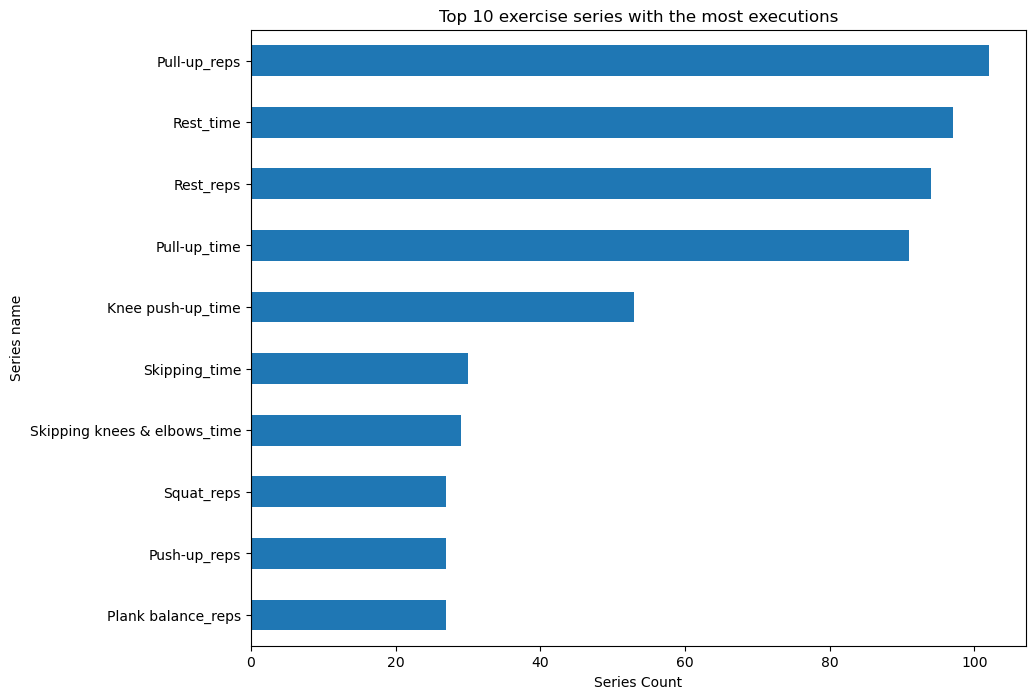

In [42]:
words_to_include = ['_time$', '_reps$']

range_max_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_max_reps,
   'title' : 'Top ' + str(range_max_reps[1]) + ' exercise series with the most executions',
   'xlabel' : 'Series Count',
   'ylabel' : 'Series name'
}

plot_of_columns_based_on_regex(max_values, plot_conf, words_to_include)

The previous graph indicates the max number of series executed during a session execution. For example the **Pallof press (left)_reps** indicates that the max value in a session execution for that exercise was almost 20 series.

### Max number of single rep exercises

Jumping squat with weight_reps_1    2.111101e+09
Windshield wiper_reps_4             2.074569e+08
Weighted backward lunge_reps_2      6.666667e+07
Forward thrust_reps_1               5.444426e+07
Push-up_reps_8                      9.999999e+06
Squat_reps_5                        9.999999e+06
Squat_reps_1                        9.999990e+05
Push-up_reps_3                      9.999990e+05
Burpee_reps_1                       8.888880e+05
Weighted backward lunge_reps_3      5.555550e+05
Name: max, dtype: float64


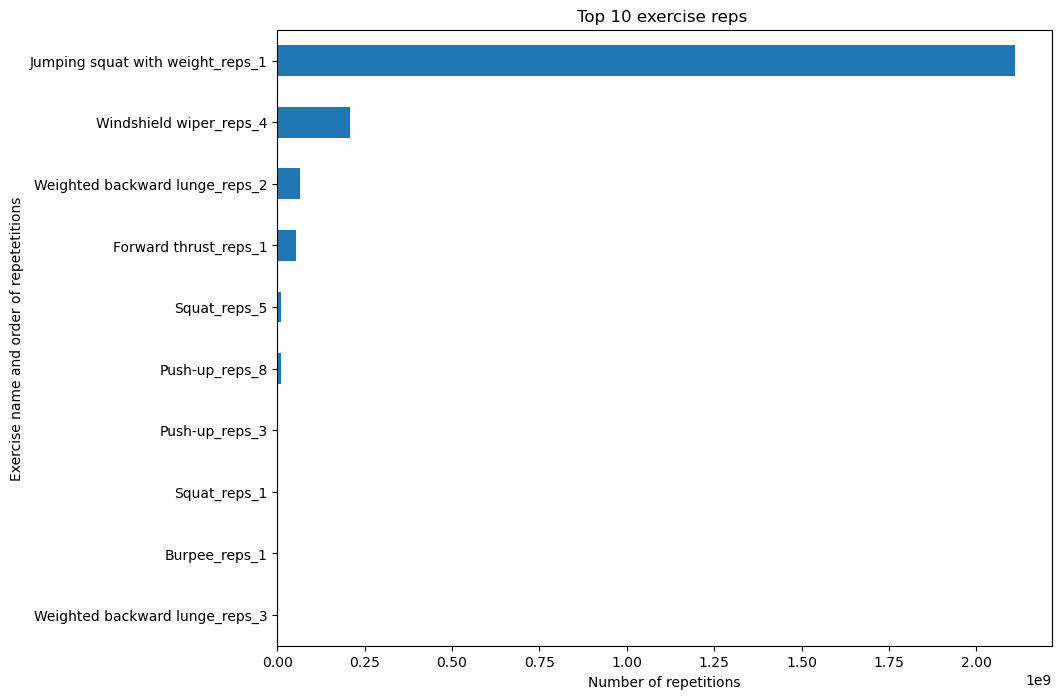

In [43]:
words_to_include = ['_reps_\d']

range_max_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_max_reps,
   'title' : 'Top ' + str(range_max_reps[1]) + ' exercise reps ',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Exercise name and order of repetetitions'
}

plot_of_columns_based_on_regex(max_values, plot_conf, words_to_include)


### Max number of single time exercises

Diver_time_1                  4893.0
Pivot lunges (left)_time_2    3861.0
Rest_time_1                   3752.0
Plank balance_time_1          3719.0
Rest_time_2                   3667.0
Plank_time_1                  3655.0
Plank_time_2                  3648.0
Flow e_time_4                 3602.0
Mountain climber_time_1       3556.0
Hip thrust_time_1             3515.0
Name: max, dtype: float64


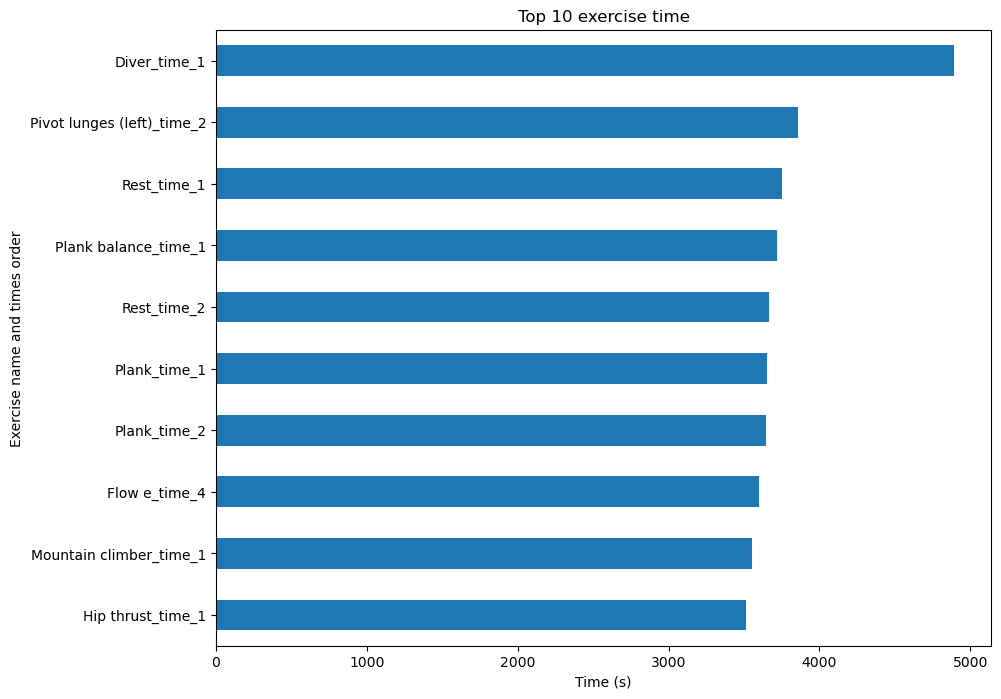

In [44]:
words_to_include= ['_time_\d']

range_max_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_max_reps,
   'title' : 'Top ' + str(range_max_reps[1]) + ' exercise time',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Exercise name and times order'
}

plot_of_columns_based_on_regex(max_values, plot_conf, words_to_include)


### Max number of the sum of repetitions per exercises

Jumping squat with weight_total_reps_per_exercise    2.111101e+09
Windshield wiper_total_reps_per_exercise             2.075805e+08
Weighted backward lunge_total_reps_per_exercise      6.722224e+07
Forward thrust_total_reps_per_exercise               5.444426e+07
Push-up_total_reps_per_exercise                      1.113099e+07
Squat_total_reps_per_exercise                        1.102100e+07
Burpee_total_reps_per_exercise                       8.889160e+05
Pull-up with rings 1_total_reps_per_exercise         2.700000e+05
Squat with rings_total_reps_per_exercise             4.800000e+04
Plank with rings_total_reps_per_exercise             3.337000e+04
Name: max, dtype: float64


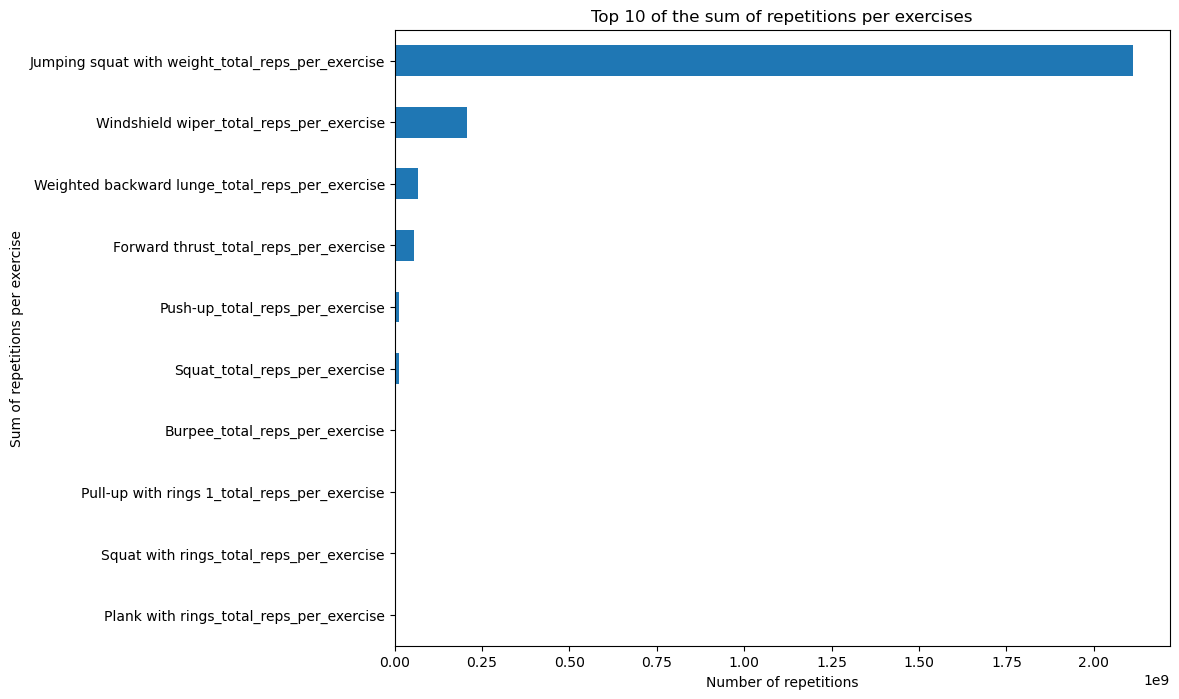

In [45]:
words_to_include = ['_total_reps_per_exercise']

range_max_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_max_reps,
   'title' : 'Top ' + str(range_max_reps[1]) + ' of the sum of repetitions per exercises',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Sum of repetitions per exercise'
}

plot_of_columns_based_on_regex(max_values, plot_conf, words_to_include)

### Max number of the sum of time per exercise

Rest_total_time_per_exercise                             42736.0
Eccentric subescapular (left)_total_time_per_exercise    10133.0
Leg raises_total_time_per_exercise                        9284.0
Hip thrust_total_time_per_exercise                        8728.0
Goblet squat_total_time_per_exercise                      7879.0
Weighted backward lunge_total_time_per_exercise           7522.0
Plank_total_time_per_exercise                             7303.0
Hindu push-up_total_time_per_exercise                     7003.0
Weighted side lunge_total_time_per_exercise               6649.0
Neck strecht_total_time_per_exercise                      5853.0
Name: max, dtype: float64


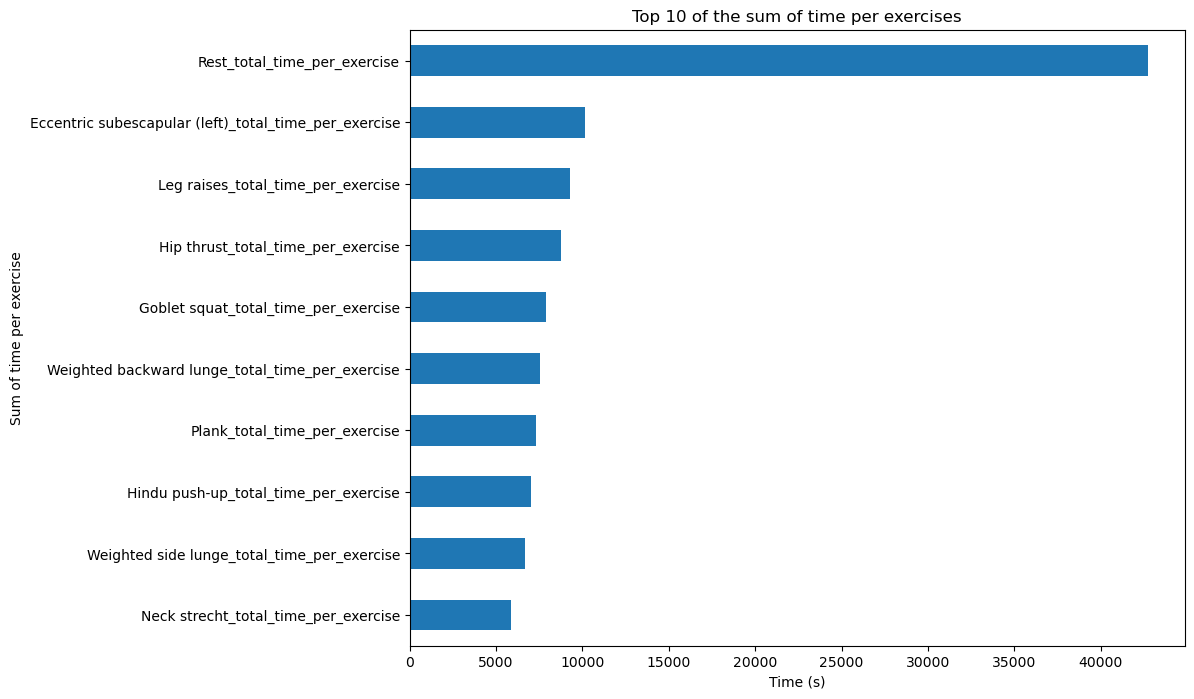

In [46]:
words_to_include = ['_total_time_per_exercise']

range_max_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_max_reps,
   'title' : 'Top ' + str(range_max_reps[1]) + ' of the sum of time per exercises',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Sum of time per exercise'
}

plot_of_columns_based_on_regex(max_values, plot_conf, words_to_include)

### Total Reps

C:\Users\eVida-PC\AppData\Local\Temp\ipykernel_8176\51591889.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_total_reps = top_total_reps[range_max[0]:range_max[1]]


Text(0, 0.5, 'Index of sessions')

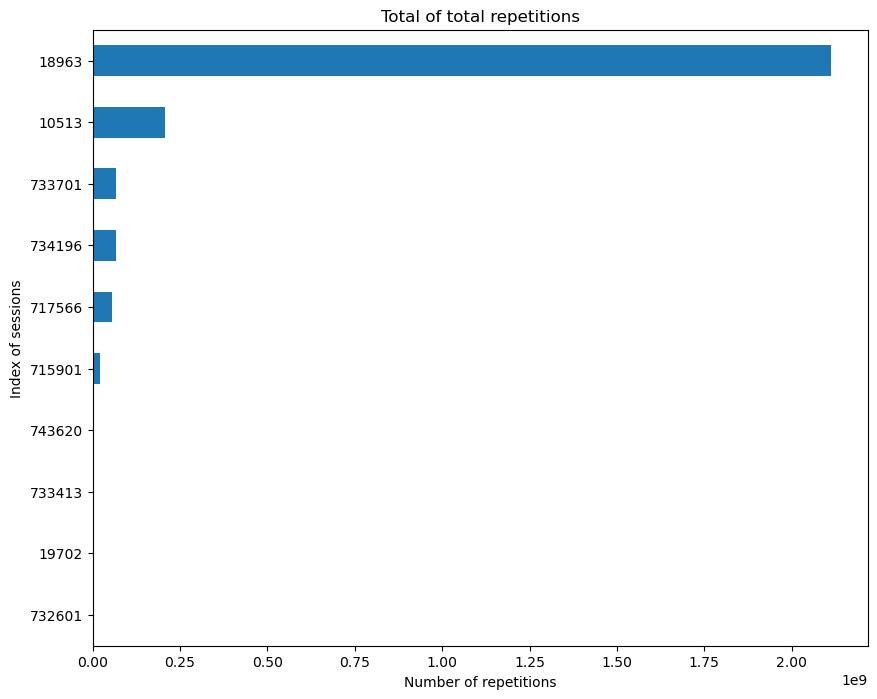

In [47]:
range_max = (0,10)
top_total_reps = df_series_recalculated['total_reps'].sort_values(ascending=False)
top_total_reps = top_total_reps[range_max[0]:range_max[1]]
# Sorting and plotting
ax_reps = top_total_reps.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))

# Set title and labels
ax_reps.set_title('Total of total repetitions')
ax_reps.set_xlabel('Number of repetitions')
ax_reps.set_ylabel('Index of sessions')

### Total time

C:\Users\eVida-PC\AppData\Local\Temp\ipykernel_8176\2455161470.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_total_time = top_total_time[range_max[0]:range_max[1]]


Text(0, 0.5, 'Index of sessions')

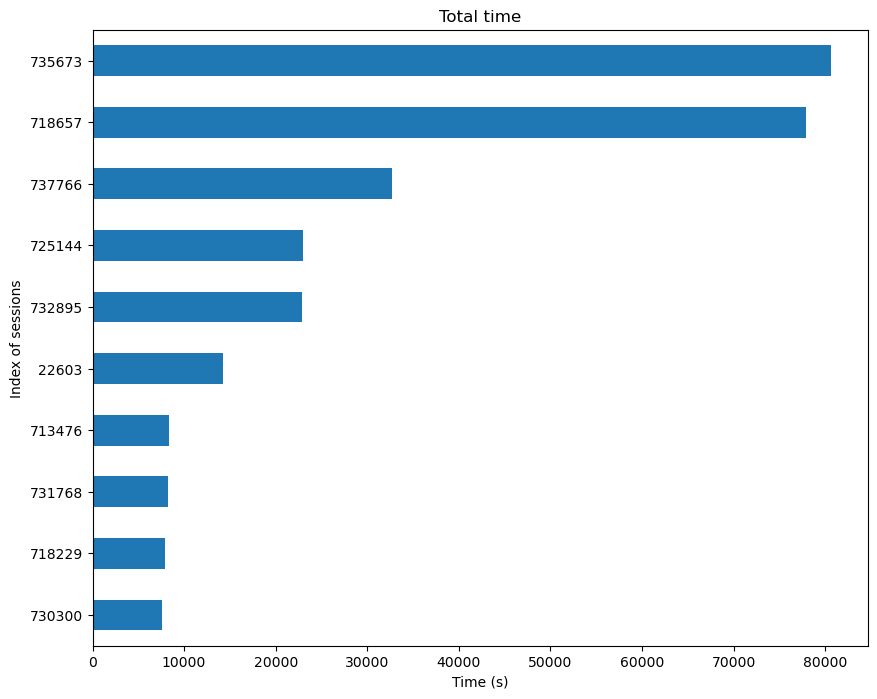

In [48]:
range_max = (0,10)
top_total_time = df_series_recalculated['total_time'].sort_values(ascending=False)
top_total_time = top_total_time[range_max[0]:range_max[1]]
# Sorting and plotting
ax = top_total_time.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))

# Set title and labels
ax.set_title('Total time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Index of sessions')

## Description of median by removing zeros

In [49]:
df_describe_zeros_excluded = df_series_recalculated.mask(df_series_recalculated==0).describe()

In [50]:
def get_median(df):
    
    # Drop the columns that we do not want to be included in the graph
    df = df.drop(columns=columns_to_remove)

    # Get the median od columns
    median_zeros_excluded = df.loc['50%', :].sort_values(ascending = False)

    return median_zeros_excluded

median_zeros_excluded = get_median(df_describe_zeros_excluded)

### Median of exercise series

#### Top 10 values

len_max_series:  882


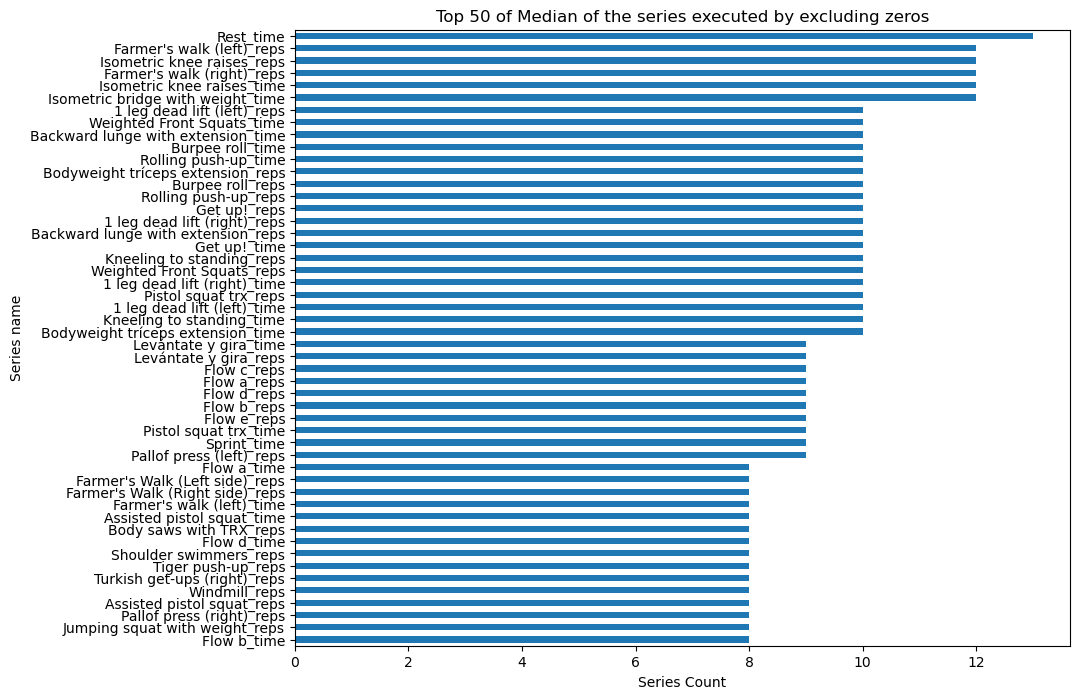

In [76]:
words_to_include = ['_time$', '_reps$']

range_values = (0,50)

plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Top ' + str(range_values[1]) + ' of Median of the series executed by excluding zeros',
   'xlabel' : 'Series Count',
   'ylabel' : 'Series name'
}

plot_of_columns_based_on_regex(median_zeros_excluded, plot_conf, words_to_include, ascending = True)

#### Bottom 10 values

len_max_series:  882


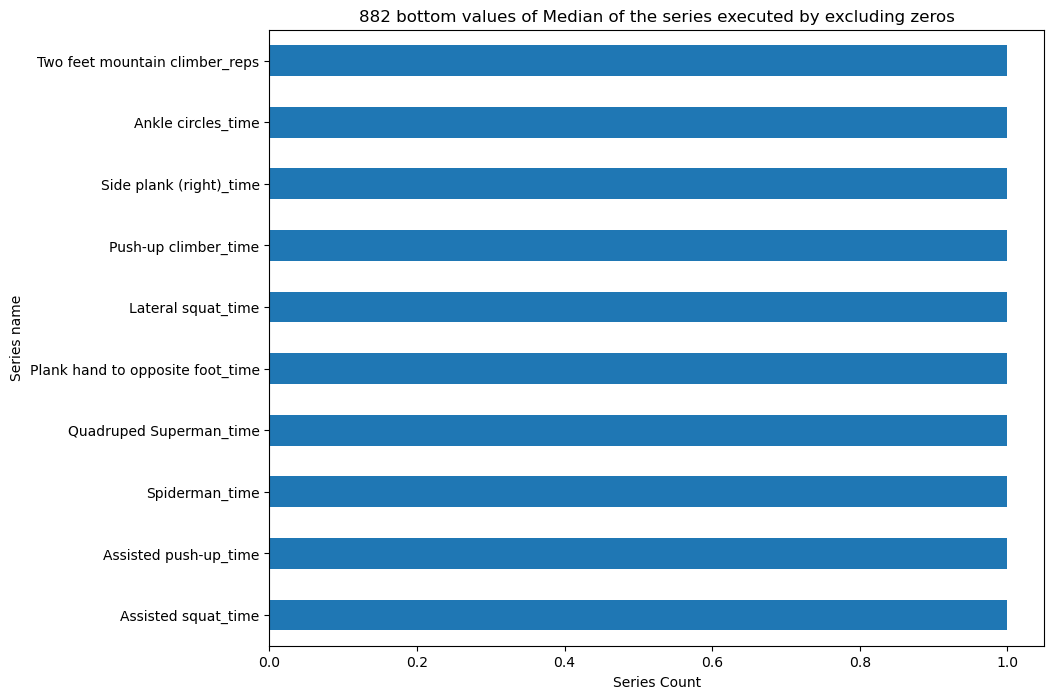

In [81]:
words_to_include = ['_time$', '_reps$']

range_values = (872,882)

plot_conf = {
   'range_values_to_plot' : range_values,
   'title' :  str(range_values[1]) + ' bottom values of Median of the series executed by excluding zeros',
   'xlabel' : 'Series Count',
   'ylabel' : 'Series name'
}

plot_of_columns_based_on_regex(median_zeros_excluded, plot_conf, words_to_include)

### Median of single rep exercises

#### Top 10 values

len_max_series:  3352


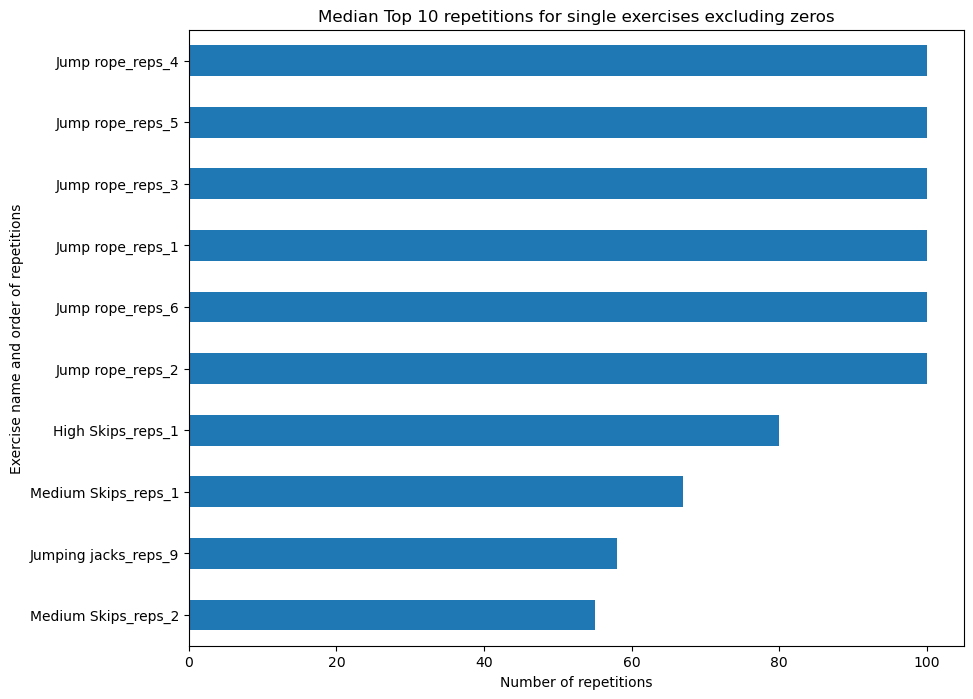

In [75]:
words_to_include = ['_reps_\d']

range_values = (0,10)
plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Median Top ' + str(range_values[1]) + ' repetitions for single exercises excluding zeros',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Exercise name and order of repetitions'
}

plot_of_columns_based_on_regex(median_zeros_excluded, plot_conf, words_to_include)

#### Bottom 10 values

len_max_series:  3352


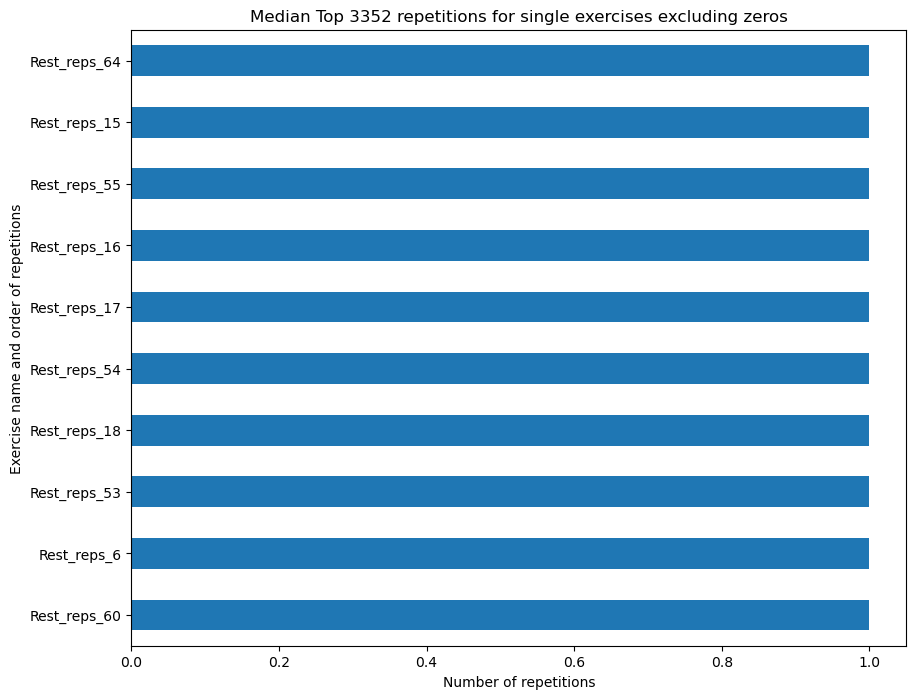

In [82]:
words_to_include = ['_reps_\d']

range_values = (3342,3352)
plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Median Top ' + str(range_values[1]) + ' repetitions for single exercises excluding zeros',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Exercise name and order of repetitions'
}

plot_of_columns_based_on_regex(median_zeros_excluded, plot_conf, words_to_include)

### Median of single time exercises


#### Top 10 values

len_max_series:  3550


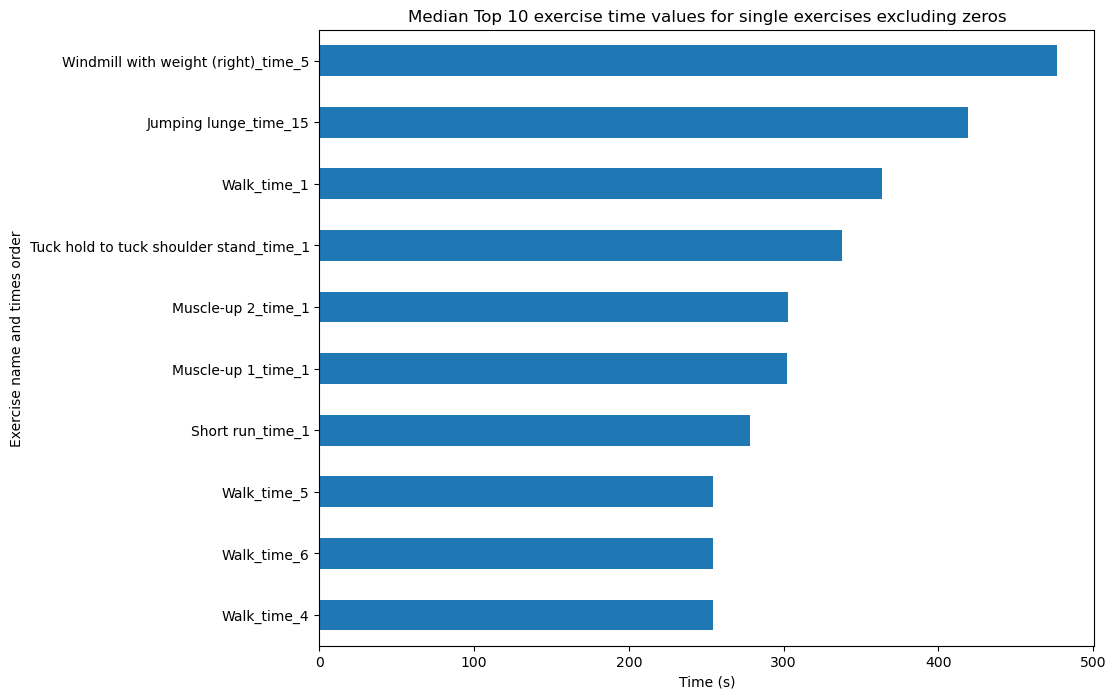

In [83]:
words_to_include= ['_time_\d']

range_values = (0,10)
plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Median Top ' + str(range_values[1]) + ' exercise time values for single exercises excluding zeros',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Exercise name and times order'
}

plot_of_columns_based_on_regex(median_zeros_excluded, plot_conf, words_to_include)

#### Bottom 10 values

len_max_series:  3550


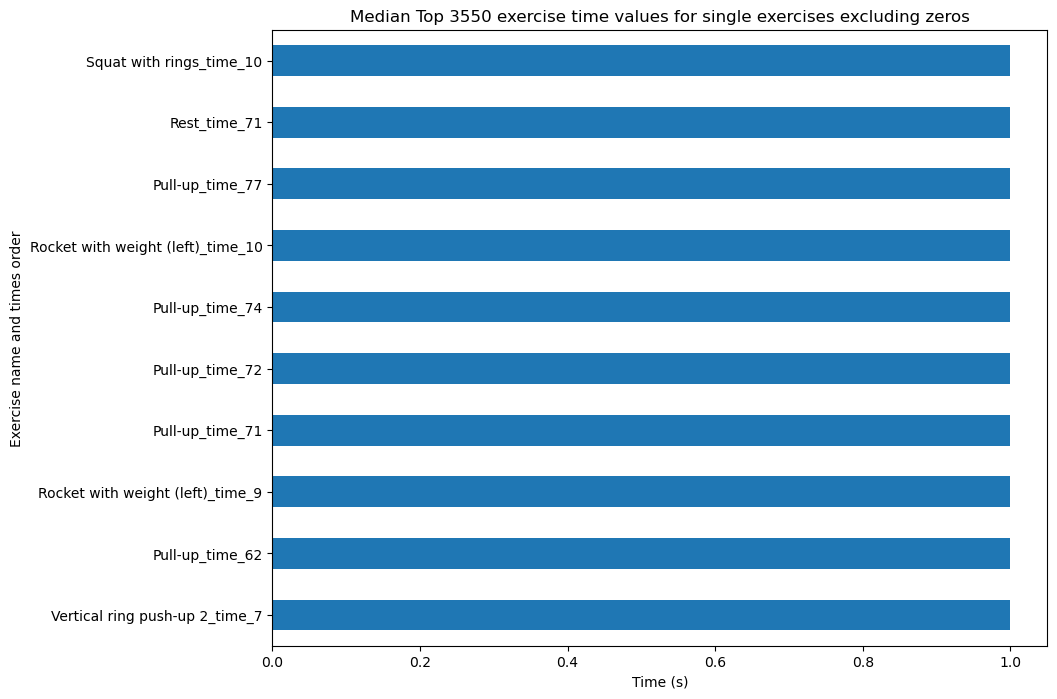

In [84]:
words_to_include= ['_time_\d']

range_values = (3540,3550)
plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Median Top ' + str(range_values[1]) + ' exercise time values for single exercises excluding zeros',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Exercise name and times order'
}

plot_of_columns_based_on_regex(median_zeros_excluded, plot_conf, words_to_include)

### Median of the sum of repetitions per exercises

#### Top 10 values

len_max_series:  430


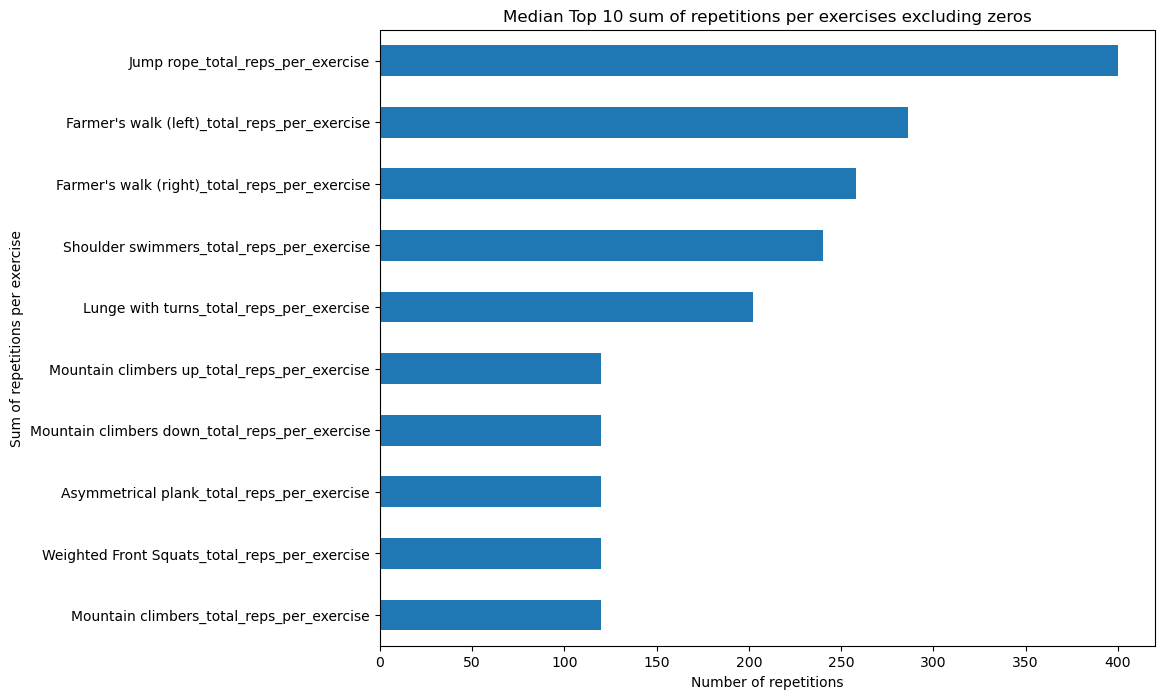

In [85]:
### Max number of the sum of repetitions per exercises
words_to_include = ['_total_reps_per_exercise']

range_max_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_max_reps,
   'title' : 'Median Top ' + str(range_max_reps[1]) + ' sum of repetitions per exercises excluding zeros',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Sum of repetitions per exercise'
}
plot_of_columns_based_on_regex(median_zeros_excluded, plot_conf, words_to_include)

#### Bottom 10 values

len_max_series:  430


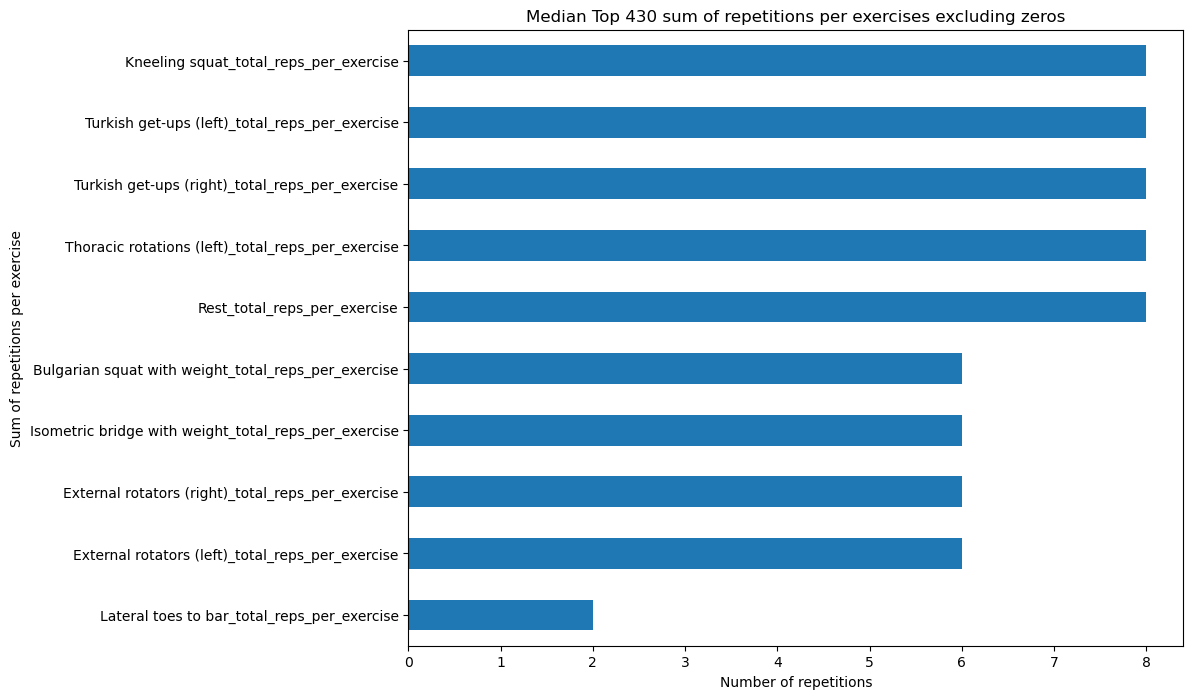

In [86]:
### Max number of the sum of repetitions per exercises
words_to_include = ['_total_reps_per_exercise']

range_max_reps = (420,430)
plot_conf = {
   'range_values_to_plot' : range_max_reps,
   'title' : 'Median Top ' + str(range_max_reps[1]) + ' sum of repetitions per exercises excluding zeros',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Sum of repetitions per exercise'
}
plot_of_columns_based_on_regex(median_zeros_excluded, plot_conf, words_to_include)

### Median of the sum of time per exercises

#### Top 10 values

len_max_series:  452


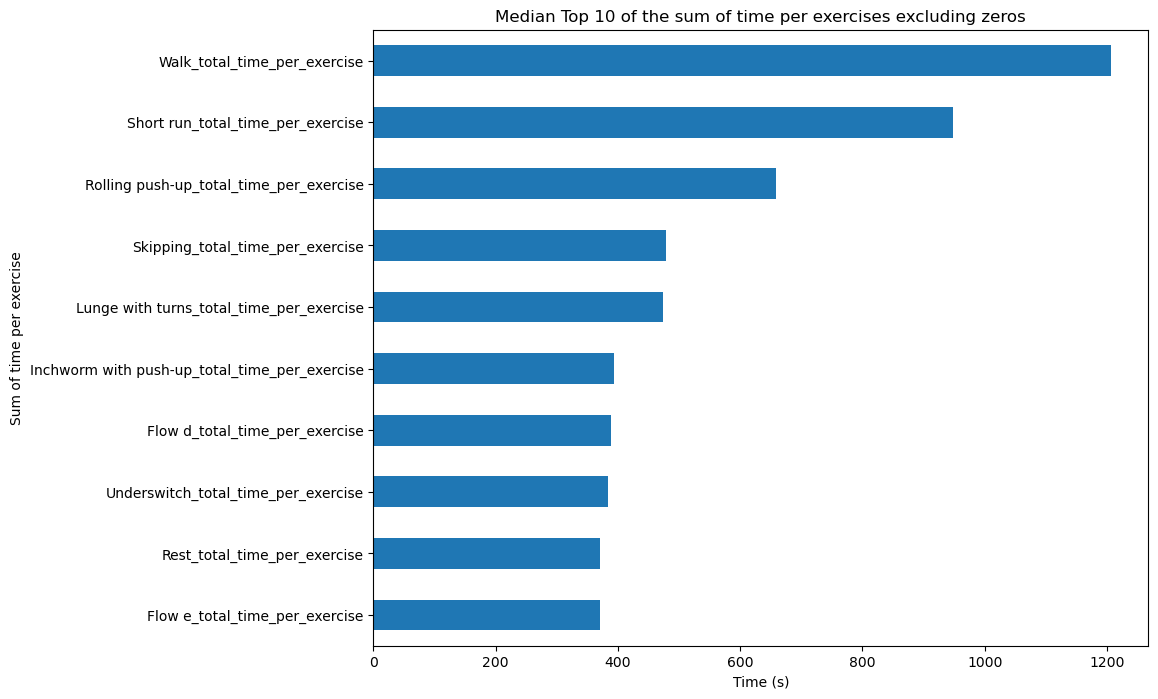

In [90]:
words_to_include = ['_total_time_per_exercise']

range_max_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_max_reps,
   'title' : 'Median Top ' + str(range_max_reps[1]) + ' of the sum of time per exercises excluding zeros',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Sum of time per exercise'
}

plot_of_columns_based_on_regex(median_zeros_excluded, plot_conf, words_to_include)

In [ ]:
#### Bottom 10 values

len_max_series:  452


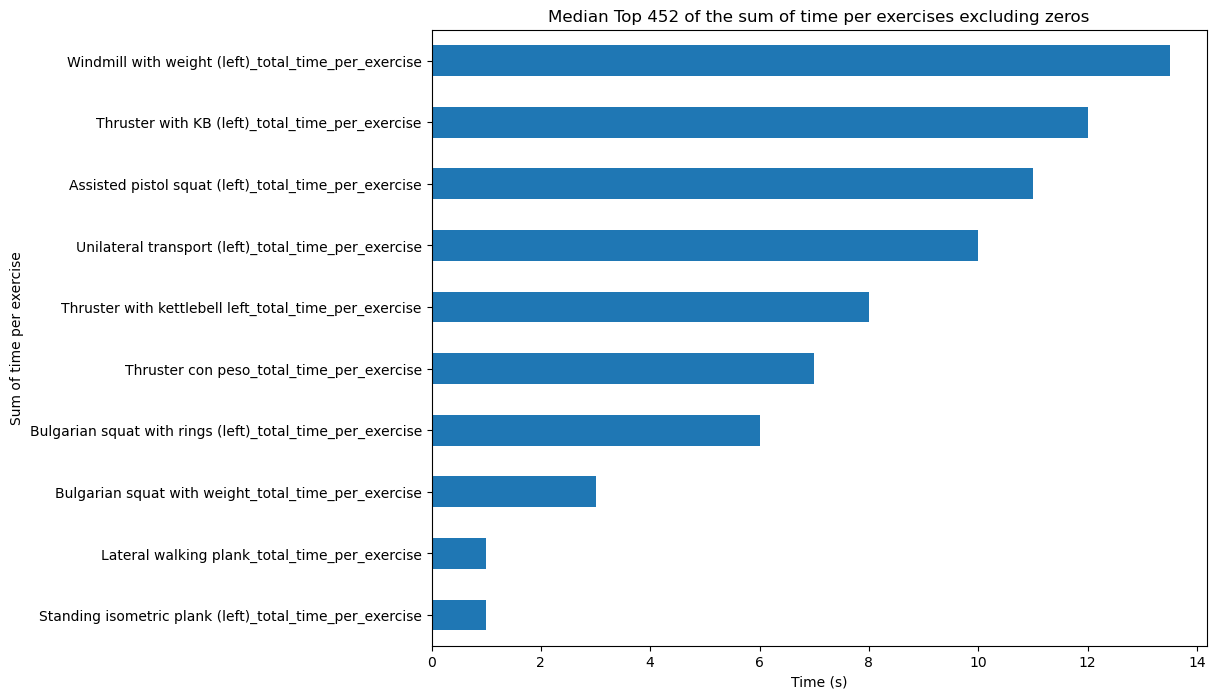

In [91]:
words_to_include = ['_total_time_per_exercise']

range_max_reps = (442,452)
plot_conf = {
   'range_values_to_plot' : range_max_reps,
   'title' : 'Median Top ' + str(range_max_reps[1]) + ' of the sum of time per exercises excluding zeros',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Sum of time per exercise'
}

plot_of_columns_based_on_regex(median_zeros_excluded, plot_conf, words_to_include)